## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [1]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !brew install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

'items.csv'

In [185]:
import pandas as pd
import numpy as np

pd.read_csv('users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [187]:
df = pd.read_csv('train_part.csv')
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [188]:
df.last_watch_dt.min(), df.last_watch_dt.max()

('2021-03-13', '2021-08-12')

In [189]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3132844,528610,6876,118,8154,100.0,1
1713905,113041,11531,85,1,0.0,0
576810,1075554,9164,40,393,7.0,0
2063355,571845,10440,95,141352,90.0,1
2537158,815552,1281,106,7008,100.0,1


<Axes: >

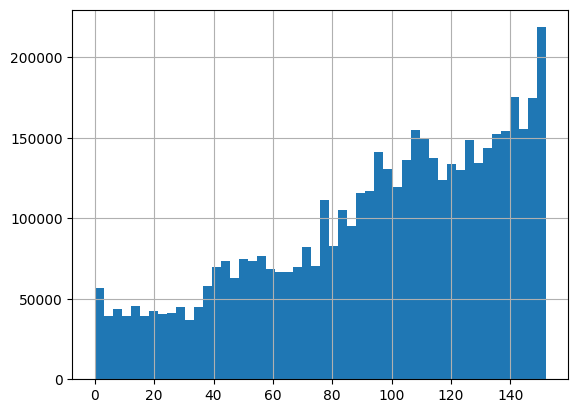

In [190]:
df.last_watch_dt.hist(bins=50)

In [191]:
train_stage_1 = df.loc[(df.last_watch_dt < 135)].copy()
valid_stage_1 = df.loc[(df.last_watch_dt >= 135)].copy()

train_users = train_stage_1.user_id.unique()
test_users = valid_stage_1.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей трейн:', train_users.shape[0])
print('число людей валидация:', test_users.shape[0])

число людей и там и там:  154133
число людей трейн: 742224
число людей валидация: 292330


In [192]:
train_stage_1 = train_stage_1.loc[train_stage_1.user_id.isin(all_included)].copy()
valid_stage_1 = valid_stage_1.loc[valid_stage_1.user_id.isin(all_included)].copy()

assert train_stage_1.last_watch_dt.max() < valid_stage_1.last_watch_dt.min()
assert train_stage_1.user_id.nunique() == valid_stage_1.user_id.nunique()

In [193]:
train_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
1,952323,15997,0,7507,100.0,1
2,889459,11460,0,60,0.0,0
5,372891,1572,0,6617,93.0,1
7,20758,14317,0,2750,42.0,0
14,713914,14230,0,3552,51.0,1


In [194]:
item2id = {k: v for v, k in enumerate(train_stage_1.item_id.unique())}
user2id = {k:v for v, k in enumerate(train_stage_1.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

train_stage_1['user_id'] = train_stage_1.user_id.apply(lambda x: user2id[x])
train_stage_1['item_id'] = train_stage_1.item_id.apply(lambda x: item2id[x])

train_stage_1.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
312458,5936,5395,22,15040,100.0,1
3219652,72006,235,120,890,14.0,0
3048465,21669,9645,116,1014,17.0,0
3343222,84816,6288,123,138199,55.0,1
2473885,37832,11778,104,7231,100.0,1


In [195]:
valid_stage_1['user_id'] = valid_stage_1.user_id.apply(lambda x: user2id[x])
valid_stage_1['item_id'] = valid_stage_1.item_id.apply(lambda x: item2id[x] if x in item2id else len(item2id))

valid_stage_1.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
3925225,125960,912,135,8306,100.0,1
4089791,90583,2584,138,5132,97.0,1
4431632,128881,4099,145,723,9.0,0
4602554,39424,1237,148,630,8.0,0
4152104,139273,12092,140,3596,40.0,0


In [196]:
train_grouped = train_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, 
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = valid_stage_1.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/927104161.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_stage_1.groupby('user_id').apply(
/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/927104161.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = valid_stage_1.groupby('user_id').apply(


,user_id,train_interactions
0,0,"[(0, 0), (906, 0), (4669, 14), (56, 15), (5544..."
1,1,"[(1, 0), (6399, 40), (7339, 45), (10, 46), (30..."
2,2,"[(2, 0), (159, 0), (189, 4), (7131, 27), (279,..."
3,3,"[(3, 0), (456, 0), (70, 0), (1883, 2), (2486, ..."
4,4,"[(4, 0), (45, 0), (2628, 3), (3610, 5), (1611,..."


In [197]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,0,"[(0, 0), (906, 0), (4669, 14), (56, 15), (5544...","[(10076, 140)]"
1,1,"[(1, 0), (6399, 40), (7339, 45), (10, 46), (30...","[(720, 135), (155, 136), (386, 137), (515, 138..."
2,2,"[(2, 0), (159, 0), (189, 4), (7131, 27), (279,...","[(9504, 137)]"
3,3,"[(3, 0), (456, 0), (70, 0), (1883, 2), (2486, ...","[(14, 144)]"
4,4,"[(4, 0), (45, 0), (2628, 3), (3610, 5), (1611,...","[(9903, 147)]"


In [198]:
def ndcg_metric(gt_items, predicted):
    predicted = [first for first, _ in predicted]
    at = len(predicted)
    relevance = np.array([1 if x in gt_items else 0 for x in predicted])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    predicted = [first for first, _ in predicted]
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / min(n_gt, len(gt_items))



def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return {'ndcg':np.mean([x[0] for x in metric_values]),
            'recall':np.mean([x[1] for x in metric_values])}

In [199]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_stage_1.shape[0]), (train_stage_1['user_id'], train_stage_1['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<154133x13106 sparse matrix of type '<class 'numpy.float64'>'
	with 1602543 stored elements in COOrdinate format>

### EASE

In [16]:
class EASE:
    def __init__(self):
        self.w = None

    def fit_ease(self, X, reg_weight=2000):
        
        # gram matrix
        G = X.T @ X
    
        # add reg to diagonal
        G += reg_weight * sps.identity(G.shape[0])
    
        # convert to dense because inverse will be dense
        G = G.todense()
    
        # invert. this takes most of the time
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        # zero out diag
        np.fill_diagonal(B, 0.)
        
        self.w = B

    def get_preds(self, x, topk=40):

        encoded = [t[0] for t in x]
    
        # Составляем вектор интеракций человека
        vector = np.zeros(len(item2id)) # n_items
        vector[encoded] = 1
    
        vector = sps.csr_matrix(vector)
    
        preds = np.array(vector.dot(self.w))[0]#.toarray()
        preds[encoded==1] = -np.inf # n_items
    
        items_final = np.argsort(-preds)
        decoded = [(t, preds[t]) for t in items_final][:topk]
        
        return decoded

In [17]:
ease_model = EASE()
ease_model.fit_ease(matrix)

In [18]:
joined['ease_preds'] = joined.train_interactions.apply(lambda x: ease_model.get_preds(x))
joined.head()

,user_id,train_interactions,test_interactions,ease_preds
0,0,"[(0, 0), (906, 0), (4669, 14), (56, 15), (5544...","[(10076, 140)]","[(10076, 0.2819993690486225), (8393, 0.1442077..."
1,1,"[(1, 0), (6399, 40), (7339, 45), (10, 46), (30...","[(720, 135), (155, 136), (386, 137), (515, 138...","[(9563, 0.5743212031199295), (2654, 0.55076242..."
2,2,"[(2, 0), (159, 0), (189, 4), (7131, 27), (279,...","[(9504, 137)]","[(10900, 0.6239527326294154), (8432, 0.3645017..."
3,3,"[(3, 0), (456, 0), (70, 0), (1883, 2), (2486, ...","[(14, 144)]","[(165, 0.18843308397449215), (53, 0.1823137515..."
4,4,"[(4, 0), (45, 0), (2628, 3), (3610, 5), (1611,...","[(9903, 147)]","[(9563, 0.19394963186677916), (8431, 0.1519296..."


In [19]:
evaluate_recommender(joined, model_preds="ease_preds")

{'ndcg': 0.44948146107928616, 'recall': 0.31811334643863326}

### ALS

In [20]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.2 MB/s eta 0:00:0000:0100:01


In [21]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

class ALS:
    def __init__(self, interactions, n_factors: int = 100, alpha: float = 1.0, regularization: float = 0.01):
        self.als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
        self.interactions = csr_matrix(interactions)
        self.als.fit(self.interactions)
        
    def make_als_recommendations(self, user_ids, top_k: int = 40):
        recommendations, scores = self.als.recommend(user_ids, self.interactions[user_ids], N=top_k)
        return recommendations, scores

In [22]:
als_model = ALS(matrix)
als_recs, als_scores = als_model.make_als_recommendations(joined['user_id'])

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
joined['ALS_preds'] = list(zip(als_recs.tolist(), als_scores.tolist()))
joined['ALS_preds'] = joined['ALS_preds'].apply(lambda x: list(zip(x[0], x[1])))

In [24]:
joined

,user_id,train_interactions,test_interactions,ease_preds,ALS_preds
0,0,"[(0, 0), (906, 0), (4669, 14), (56, 15), (5544...","[(10076, 140)]","[(10076, 0.2819993690486225), (8393, 0.1442077...","[(2549, 0.10884371399879456), (704, 0.10393110..."
1,1,"[(1, 0), (6399, 40), (7339, 45), (10, 46), (30...","[(720, 135), (155, 136), (386, 137), (515, 138...","[(9563, 0.5743212031199295), (2654, 0.55076242...","[(696, 0.5269034504890442), (8702, 0.425881236..."
2,2,"[(2, 0), (159, 0), (189, 4), (7131, 27), (279,...","[(9504, 137)]","[(10900, 0.6239527326294154), (8432, 0.3645017...","[(690, 0.19871176779270172), (781, 0.174633949..."
3,3,"[(3, 0), (456, 0), (70, 0), (1883, 2), (2486, ...","[(14, 144)]","[(165, 0.18843308397449215), (53, 0.1823137515...","[(2654, 0.20836199820041656), (53, 0.198739096..."
4,4,"[(4, 0), (45, 0), (2628, 3), (3610, 5), (1611,...","[(9903, 147)]","[(9563, 0.19394963186677916), (8431, 0.1519296...","[(8584, 0.17757992446422577), (4566, 0.1710144..."
...,...,...,...,...,...
154128,154128,"[(8187, 134)]","[(2033, 142)]","[(10076, 0.07618992803898605), (2033, 0.046706...","[(2033, 0.09189043939113617), (8584, 0.0796022..."
154129,154129,"[(10900, 134)]","[(8432, 140), (13106, 146)]","[(8432, 0.13614468728974435), (10861, 0.130175...","[(11030, 0.008582140319049358), (10552, 0.0078..."
154130,154130,"[(13002, 134)]","[(11778, 135), (12436, 135), (7558, 135), (109...","[(11778, 0.05985174857076015), (8393, 0.045321...","[(6796, 0.10644617676734924), (9973, 0.0848553..."
154131,154131,"[(8432, 134)]","[(2859, 141), (7131, 141), (1575, 141)]","[(10076, 0.16733470447963453), (10900, 0.12839...","[(2859, 0.010997765697538853), (738, 0.0065198..."


In [25]:
evaluate_recommender(joined, model_preds="ALS_preds")

{'ndcg': 0.17571794356044496, 'recall': 0.10102091631921253}

### SASRec

In [466]:
users = pd.read_csv("users.csv")
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [467]:
age_feature = users[['user_id', 'age']]
age_feature.columns = ['id', 'value']
age_feature['feature'] = "age"
age_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/1949623956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_feature['feature'] = "age"


,id,value,feature
0,973171,age_25_34,age
1,962099,age_18_24,age
2,1047345,age_45_54,age
3,721985,age_45_54,age
4,704055,age_35_44,age


In [468]:
income_feature = users[['user_id', 'income']]
income_feature.columns = ['id', 'value']
income_feature['feature'] = "income"
income_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/1392557506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_feature['feature'] = "income"


,id,value,feature
0,973171,income_60_90,income
1,962099,income_20_40,income
2,1047345,income_40_60,income
3,721985,income_20_40,income
4,704055,income_60_90,income


In [469]:
sex_feature = users[['user_id', 'sex']]
sex_feature.columns = ['id', 'value']
sex_feature['feature'] = "sex"
sex_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/1403367885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_feature['feature'] = "sex"


,id,value,feature
0,973171,М,sex
1,962099,М,sex
2,1047345,Ж,sex
3,721985,Ж,sex
4,704055,Ж,sex


In [470]:
kids_flg_feature = users[['user_id', 'kids_flg']]
kids_flg_feature.columns = ['id', 'value']
kids_flg_feature['feature'] = "kids_flg"
kids_flg_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/2069945088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kids_flg_feature['feature'] = "kids_flg"


,id,value,feature
0,973171,1,kids_flg
1,962099,0,kids_flg
2,1047345,0,kids_flg
3,721985,0,kids_flg
4,704055,0,kids_flg


In [471]:
user_features = pd.concat((age_feature, income_feature, sex_feature, kids_flg_feature))
user_features

,id,value,feature
0,973171,age_25_34,age
1,962099,age_18_24,age
2,1047345,age_45_54,age
3,721985,age_45_54,age
4,704055,age_35_44,age
...,...,...,...
840192,339025,0,kids_flg
840193,983617,1,kids_flg
840194,251008,0,kids_flg
840195,590706,0,kids_flg


In [472]:
items = pd.read_csv("items.csv")
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [473]:
content_type_feature = items[['item_id', 'content_type']]
content_type_feature.columns = ['id', 'value']
content_type_feature['feature'] = "content_type"
content_type_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/123416927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_type_feature['feature'] = "content_type"


,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [474]:
release_year_feature = items[['item_id', 'release_year']]
release_year_feature.columns = ['id', 'value']
release_year_feature['feature'] = "release_year"
release_year_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/2504382256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  release_year_feature['feature'] = "release_year"


,id,value,feature
0,10711,2002.0,release_year
1,2508,2014.0,release_year
2,10716,2011.0,release_year
3,7868,2015.0,release_year
4,16268,1978.0,release_year


In [475]:
items['genres'] = items.genres.str.lower().str.replace(', ', ',', regex=False).str.split(',')
genres_feature = items[['item_id', 'genres']].explode("genres")
genres_feature.columns = ['id', 'value']
genres_feature['feature'] = "genre"
genres_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [476]:
items['countries'] = items.countries.str.lower().str.replace(', ', ',', regex=False).str.split(',')
countries_feature = items[['item_id', 'countries']].explode("countries")
countries_feature.columns = ['id', 'value']
countries_feature['feature'] = "countries"
countries_feature.head()

,id,value,feature
0,10711,испания,countries
1,2508,сша,countries
2,10716,канада,countries
3,7868,великобритания,countries
4,16268,ссср,countries


In [477]:
for_kids_feature = items[['item_id', 'for_kids']]
for_kids_feature.columns = ['id', 'value']
for_kids_feature['feature'] = "for_kids"
for_kids_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/467872145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_kids_feature['feature'] = "for_kids"


,id,value,feature
0,10711,NaN,for_kids
1,2508,NaN,for_kids
2,10716,NaN,for_kids
3,7868,NaN,for_kids
4,16268,NaN,for_kids


In [478]:
age_rating_feature = items[['item_id', 'age_rating']]
age_rating_feature.columns = ['id', 'value']
age_rating_feature['feature'] = "age_rating"
age_rating_feature.head()

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/3701540029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_rating_feature['feature'] = "age_rating"


,id,value,feature
0,10711,16.0,age_rating
1,2508,16.0,age_rating
2,10716,16.0,age_rating
3,7868,16.0,age_rating
4,16268,12.0,age_rating


In [479]:
items['studios'] = items.studios.str.lower().str.replace(', ', ',', regex=False).str.split(',')
studios_feature = items[['item_id', 'studios']].explode("studios")
studios_feature.columns = ['id', 'value']
studios_feature['feature'] = "studios"
studios_feature.head()

,id,value,feature
0,10711,NaN,studios
1,2508,NaN,studios
2,10716,NaN,studios
3,7868,NaN,studios
4,16268,ленфильм,studios


In [480]:
items['directors'] = items.directors.str.lower().str.replace(', ', ',', regex=False).str.split(',')
directors_feature = items[['item_id', 'directors']].explode("directors")
directors_feature.columns = ['id', 'value']
directors_feature['feature'] = "directors"
directors_feature.head()

,id,value,feature
0,10711,педро альмодовар,directors
1,2508,скот армстронг,directors
2,10716,адам п. калтраро,directors
3,7868,эндрю хэй,directors
4,16268,виктор садовский,directors


In [481]:
items['actors'] = items.actors.str.lower().str.replace(', ', ',', regex=False).str.split(',')
actors_feature = items[['item_id', 'actors']].explode("actors")
actors_feature.columns = ['id', 'value']
actors_feature['feature'] = "actors"
actors_feature.head()

,id,value,feature
0,10711,адольфо фернандес,actors
0,10711,ана фернандес,actors
0,10711,дарио грандинетти,actors
0,10711,джеральдин чаплин,actors
0,10711,елена анайя,actors


In [482]:
item_features = pd.concat((content_type_feature, release_year_feature, genres_feature, countries_feature, for_kids_feature, age_rating_feature, studios_feature, directors_feature, actors_feature))
item_features

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type
...,...,...,...
15961,4538,джудит родди,actors
15961,4538,марк о’халлоран,actors
15961,4538,джимми смоллхорн,actors
15962,3206,мкртыч арзуманян,actors


In [483]:
user_features['id'] = user_features['id'].apply(lambda x: user2id[x] if x in user2id else len(user2id))
item_features['id'] = item_features['id'].apply(lambda x: item2id[x] if x in item2id else len(item2id) + 1)

In [484]:
train_stage_1_sasrec = train_stage_1[['user_id', 'item_id', 'last_watch_dt', 'target']]
train_stage_1_sasrec.columns = ['user_id', 'item_id', 'datetime', 'weight']
train_stage_1_sasrec

,user_id,item_id,datetime,weight
1,0,0,0,1
2,1,1,0,0
5,2,2,0,1
7,3,3,0,0
14,4,4,0,1
...,...,...,...,...
3891733,98226,1075,134,1
3891734,69297,6557,134,1
3891736,154132,10861,134,1
3891737,45108,10078,134,0


In [45]:
!pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.0/202.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 49.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: attrs
    Found existing installation: attrs 25.1.0
    Uninstalling attrs-25.1.0:
      Successfully uninstalled attrs-25.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
langchain 0.3.12 requires async-timeout<5.0.0,>=4.0.0; python_version < "3.11", but you have async

In [485]:
from rectools.dataset import Dataset

dataset = Dataset.construct(
    interactions_df=train_stage_1_sasrec,
    user_features_df = user_features,
    cat_user_features = ['age', 'income', 'sex', 'kids_flg'],
    item_features_df=item_features,
    cat_item_features=["content_type", "release_year", "genre", "countries", "for_kids", "age_rating", "studios", "directors", "actors"]
)

In [486]:
from rectools.models import SASRecModel

sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=10,
    verbose=1,
    deterministic=True,
)

sasrec.fit(dataset)

ImportError: Requirement `torch` is not satisfied. Run `pip install rectools[torch]` to install extra requirements before accessing SASRecModel.

In [48]:
recos = sasrec.recommend(
    users=joined.user_id,
    dataset=dataset,
    k=40,
    filter_viewed=True,
    on_unsupported_targets="warn"
)

recos

/usr/local/lib/python3.10/dist-packages/rectools/models/nn/transformers/data_preparator.py:332: UserWarning: 33 target users were considered cold because of missing known items
  warnings.warn(explanation)
/usr/local/lib/python3.10/dist-packages/rectools/models/base.py:695: UserWarning: 
                Model `<class 'rectools.models.nn.transformers.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


,user_id,item_id,score,rank
0,0,10076,6.330973,1
1,0,8432,4.127128,2
2,0,11778,4.087265,3
3,0,8400,3.640872,4
4,0,10900,3.608007,5
...,...,...,...,...
6163995,154132,235,1.013708,36
6163996,154132,1975,0.918992,37
6163997,154132,681,0.916548,38
6163998,154132,12,0.894720,39


In [49]:
recos_grouped = recos.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, 
                                                 x.score), key=lambda x: x[1])]
).reset_index()
recos_grouped.rename({0:'SASRec_recs'}, axis=1, inplace=True)

<ipython-input-49-022aa43dbf63>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recos_grouped = recos.groupby('user_id').apply(


In [50]:
recos_grouped

,user_id,SASRec_recs
0,0,"[(13002, 1.3098746538162231), (9442, 1.3366973..."
1,1,"[(1135, 1.9125937223434448), (3, 1.96213543415..."
2,2,"[(11635, 1.4137260913848877), (9504, 1.4300671..."
3,3,"[(1852, 2.0031280517578125), (630, 2.008370161..."
4,4,"[(6655, 2.188267946243286), (8584, 2.215096712..."
...,...,...
154095,154128,"[(7333, 1.2350375652313232), (860, 1.247463226..."
154096,154129,"[(681, 0.7553496360778809), (70, 0.77780133485..."
154097,154130,"[(2269, 0.9671609997749329), (86, 0.9689004421..."
154098,154131,"[(12089, 0.7309435606002808), (7654, 0.8109130..."


In [51]:
joined_sasrec = joined.merge(recos_grouped)

In [52]:
evaluate_recommender(joined_sasrec, model_preds="SASRec_recs")

{'ndcg': 0.46527319194590133, 'recall': 0.32422910972143604}

In [53]:
my_heuristic_model = ease_model
my_matrix_factorization = als_model
my_neural_network = sasrec


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [275]:
df_test = pd.read_csv("test_part.csv")
df_test

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0
...,...,...,...,...,...,...
608462,1035030,10201,2021-08-22,1154,19.0,0
608463,574452,2720,2021-08-22,9076,5.0,0
608464,700990,13865,2021-08-22,9010,100.0,1
608465,693510,7571,2021-08-22,3697,64.0,1


In [278]:
df_test['last_watch_dt'] = (pd.to_datetime(df_test['last_watch_dt']) - pd.to_datetime(df_test['last_watch_dt']).min())
df_test['last_watch_dt'] = df_test.last_watch_dt.apply(lambda x: int(str(x).split()[0]) + 153)
df_test.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
297919,165084,4475,158,893,13.0,0
63199,658180,10058,154,288,4.0,0
602550,236153,12192,162,780,0.0,0
123316,767233,734,155,2183,23.0,0
250569,303782,8636,157,1604,22.0,0


In [423]:
ovl_info = pd.concat((df, df_test)).merge(users, how='left', on=["user_id"]).merge(items, how='left', on=["item_id"])
ovl_info.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,...,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,310745,13373,0,4485,98.0,1,age_35_44,income_90_150,М,1.0,...,2011.0,"[приключения, мультфильм, вестерн, комедии]",[сша],NaN,0.0,NaN,[дункан макнили],"[брайан адамс, дональд сазерленд, хелен хант, ...",История приключений очаровательного и бесстраш...,"2011, соединенные штаты, джок"
1,952323,15997,0,7507,100.0,1,age_35_44,income_40_60,Ж,0.0,...,2020.0,[комедии],"[великобритания, италия]",NaN,12.0,NaN,[джеймс д’арси],"[лиам нисон, майкл ричардсон, иоланда кеттл, с...",Известный лондонский художник Роберт приезжает...,"художник, тоскана, италия, 2020, соединенное к..."
2,889459,11460,0,60,0.0,0,age_25_34,income_40_60,Ж,1.0,...,2019.0,"[фэнтези, мелодрамы]",[республика корея],NaN,16.0,NaN,[о чхун-хван],"[ли джи-ын, ё джин-гу, чо хён-чхоль, пак ю-на,...",Из-за странного происшествия парень начинает р...,"отель, ужасы, роман, менеджер отеля, привидени..."
3,854016,11237,0,5381,98.0,1,age_45_54,income_60_90,М,1.0,...,2021.0,[комедии],[россия],NaN,16.0,NaN,[алексей харитонов],"[катерина шпица, антон филипенко, павел ворожц...",Эта история случилась в провинциальном городке...,"2021, россия, день, города"
4,307257,9132,0,5814,100.0,1,age_55_64,income_20_40,Ж,0.0,...,2016.0,[комедии],[сша],NaN,18.0,NaN,"[джон лукас, скотт мур]","[кэтрин хан, кристен белл, кристина эпплгейт, ...","Идеальная мать, прекрасная жена, хорошая домох...","алкоголь, бар, наезд, вечеринка, развод, семья..."


Функция, чтобы вторым способом считать признаки (т.е. честно на каждый день)

In [424]:
def get_cum_mean_by_features(metrics_to_groupby: list[str]):
    group_size = 1
    for metric in metrics_to_groupby:
        group_size *= ovl_info[metric].nunique()
    
    metrics_to_groupby.append("last_watch_dt")
    metrics_to_groupby[0], metrics_to_groupby[-1] = metrics_to_groupby[-1], metrics_to_groupby[0]

    mean_watch_pct = ovl_info.groupby(metrics_to_groupby)['watched_pct'].mean() * ovl_info.groupby(metrics_to_groupby)['watched_pct'].count()
    cumsum_watch_pct = ovl_info.groupby(metrics_to_groupby)['watched_pct'].count().tolist()
    lst_1 = mean_watch_pct.tolist()
    lst_2 = mean_watch_pct.tolist()
    for i in range(len(lst_1)):
        if i < group_size:
            lst_2[i] = 0
        elif i < 2 * group_size:
            cumsum_watch_pct[i] += cumsum_watch_pct[i - group_size]
            lst_2[i] = lst_1[i - group_size] / cumsum_watch_pct[i - group_size]
        else:
            cumsum_watch_pct[i] += cumsum_watch_pct[i - group_size]
            lst_2[i] = (lst_2[i - group_size] * cumsum_watch_pct[i - 2 * group_size] + lst_1[i - group_size]) / cumsum_watch_pct[i - group_size]

    mean_watch_pct[:] = lst_2
    return mean_watch_pct

### User features

1

In [425]:
mean_watch_pct_age = get_cum_mean_by_features(["age"])

In [426]:
ovl_info = ovl_info.merge(mean_watch_pct_age, how='left', on=["last_watch_dt", "age"], suffixes=("", "_mean_per_age"))

2

In [429]:
mean_watch_pct_income = get_cum_mean_by_features(["income"])

In [430]:
ovl_info = ovl_info.merge(mean_watch_pct_income, how='left', on=["last_watch_dt", "income"], suffixes=("", "_mean_per_income"))

### Item features

1

In [431]:
mean_watched_pct_every_film = get_cum_mean_by_features(["item_id"])

In [432]:
ovl_info = ovl_info.merge(mean_watched_pct_every_film, how='left', on=["last_watch_dt", "item_id"], suffixes=("", "_mean_per_film"))

2

In [433]:
ovl_info["main_country"] = ovl_info['countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
mean_watched_pct_per_country = get_cum_mean_by_features(["main_country"])

In [434]:
ovl_info = ovl_info.merge(mean_watched_pct_per_country, how='left', on=["last_watch_dt", "main_country"], suffixes=("", "_mean_per_country"))

### User-item features

1

In [436]:
ovl_info['main_actor'] = ovl_info["actors"].apply(lambda x: x[0] if isinstance(x, list) else x)

In [437]:
mean_watch_pct_sex_actor = get_cum_mean_by_features(["sex", "main_actor"])

In [440]:
ovl_info = ovl_info.merge(mean_watch_pct_sex_actor, how='left', on=["last_watch_dt", "sex", "main_actor"], suffixes=("", "_mean_per_sex_actor"))

2

In [442]:
ovl_info['main_genre'] = ovl_info["genres"].apply(lambda x: x[0] if isinstance(x, list) else x)

In [443]:
mean_watch_pct_sex_genre = get_cum_mean_by_features(["sex", "main_genre"])

In [445]:
ovl_info = ovl_info.merge(mean_watch_pct_sex_genre, how='left', on=["last_watch_dt", "sex", "main_genre"], suffixes=("", "_mean_per_sex_genre"))

3

In [446]:
mean_watch_pct_kids_age_rating = get_cum_mean_by_features(["kids_flg", "age_rating"])

In [447]:
ovl_info = ovl_info.merge(mean_watch_pct_kids_age_rating, how='left', on=["last_watch_dt", "kids_flg", "age_rating"], suffixes=("", "_mean_per_kids_flg_age_rating"))

4

In [448]:
mean_watch_pct_age_release_year = get_cum_mean_by_features(["age", "release_year"])

In [449]:
ovl_info = ovl_info.merge(mean_watch_pct_age_release_year, how='left', on=["last_watch_dt", "age", "release_year"], suffixes=("", "_mean_per_age_release_year"))

5

In [450]:
ovl_info['main_director'] = ovl_info["directors"].apply(lambda x: x[0] if isinstance(x, list) else x)

In [451]:
mean_watch_pct_age_director = get_cum_mean_by_features(["age", "main_director"])

In [452]:
ovl_info = ovl_info.merge(mean_watch_pct_age_director, how='left', on=["last_watch_dt", "age", "main_director"], suffixes=("", "_mean_per_age_director"))

6

In [453]:
mean_watch_pct_age_genre = get_cum_mean_by_features(["age", "main_genre"])

In [454]:
ovl_info = ovl_info.merge(mean_watch_pct_age_genre, how='left', on=["last_watch_dt", "age", "main_genre"], suffixes=("", "_mean_per_age_genre"))

In [456]:
df_with_features = ovl_info[["user_id", "item_id", "last_watch_dt", "total_dur", "watched_pct_mean_per_age", "watched_pct_mean_per_income", "watched_pct_mean_per_film", "watched_pct_mean_per_country", "watched_pct_mean_per_sex_actor", "watched_pct_mean_per_sex_genre", "watched_pct_mean_per_kids_flg_age_rating", "watched_pct_mean_per_age_release_year", "watched_pct_mean_per_age_director", "watched_pct_mean_per_age_genre"]]

In [457]:
df_with_features

,user_id,item_id,last_watch_dt,total_dur,watched_pct_mean_per_age,watched_pct_mean_per_income,watched_pct_mean_per_film,watched_pct_mean_per_country,watched_pct_mean_per_sex_actor,watched_pct_mean_per_sex_genre,watched_pct_mean_per_kids_flg_age_rating,watched_pct_mean_per_age_release_year,watched_pct_mean_per_age_director,watched_pct_mean_per_age_genre
0,310745,13373,0,4485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,952323,15997,0,7507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,889459,11460,0,60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,854016,11237,0,5381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,307257,9132,0,5814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475418,1035030,10201,162,1154,40.115379,46.946213,42.910112,46.776028,38.690323,42.794884,44.259791,44.577668,45.897436,49.025482
5475419,574452,2720,162,9076,NaN,NaN,44.700758,46.776028,NaN,NaN,NaN,NaN,NaN,NaN
5475420,700990,13865,162,9010,46.215944,44.338526,50.327273,44.807730,NaN,NaN,49.388030,46.750620,48.812500,48.351506
5475421,693510,7571,162,3697,NaN,NaN,53.872180,50.279560,NaN,NaN,NaN,NaN,NaN,NaN


In [462]:
train_df_with_features = df_with_features[135 <= df_with_features["last_watch_dt"]][df_with_features["last_watch_dt"] <= 152]
test_df_with_features = df_with_features[153 <= df_with_features["last_watch_dt"]]

/var/folders/5q/dr1_wwq51175s4qj4dnxgsz80000gn/T/ipykernel_76211/1204212697.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df_with_features = df_with_features[135 <= df_with_features["last_watch_dt"]][df_with_features["last_watch_dt"] <= 152]



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [ ]:
# YOUR FIT PREDICT CODE HERE
model.fit()
model.predict()


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [ ]:
# YOUR CODE HERE